In [1]:
# standard imports
import sys
import numpy as np
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.integrate import solve_ivp

In [2]:
# import geometry classes
from geometry.node import node
from geometry.cell import cell
from geometry.mesh import rotationalSymmetricMesh

# problem defining operators
from problem.isentropic_navier_stokes import convection, diffusion, curl

# projection based functions
from utilities.projection import isentropic_projection, isentropic_control_projection

# utility functions
from utilities.utilities import *
from utilities.pod import get_POD, get_activations

In [3]:
# read su2 mesh file
meshio_mesh = meshio.read("./mesh_files/mesh_cylinder_quad.su2",file_format="su2")
# convert mesh into custom class
mesh = rotationalSymmetricMesh(meshio_mesh)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2


Initializing Mesh---------------------------------------------------------------
Mesh Initialization Successful!-------------------------------------------------


# Parameter List

In [4]:
# PROBLEM CONSTANTS
n = mesh.n                  # number of nodes
N = mesh.N                  # number of cells
T = 440                     # number of snapshots
mach = 0.6                  # mach number
sos = 340.29                # isentropic speed of sound
uInfty = mach * sos         # freestream velocity
Re = 100                    # Reynolds number of freeflow
dt = 0.0001                 # simulation time step
subsampling = 3             # subsampling for data
chirp = True                # chirp dataset

# POD PARAMETERS
maxPOD = 20                 # maximum number of POD modes
gamma = 1.4                 # isentropic coefficient -> material property
alpha = 1 / gamma           # inner product coefficient [(gamma - 1)/2 -> standard, 1 -> stagnation enthalpy, 1/gamma -> stagnation energy]
includeAvg = False          # include average flow in POD computation
eps = 0.99                  # reconstruction threshold

# GALERKIN PARAMETERS
stabilization = "viscosity" # stabilization method for galerkin system -> else False
epsilon = 1e-4              # weight for sobolev norm stabilization -> experimental

dt = dt * subsampling       # timestep for snapshots  
detPer = 1/(0.165*mach*sos) # detachment period = 1 / shedding frequency!

# OPTIMIZATION PARAMETERS
t0 = 0                      # start time
tmax = detPer * 10          # number of shedding periods to predict
temporalSpan = np.linspace(t0,tmax,int(tmax/dt)+1)  # temporal linspace for plotting
control0 = 0                # initial control value
gammaMax = 1000             # maximum allowable control
N = 1                       # exponential control weight in cost function
phi0 = 0                    # costate end condition
epsilon = 1e-4              # discontinuation criteria

# MISC
nondim = False              # nondimensionalization of results
visual = True               # plotting visual results
colormap = {1:"blue",2:"orange",3:"green",4:"red",5:"purple",6:"cyan"} # custom index-color map


# Data Preparation

In [5]:
# reading file data
if chirp:
    dataDir  = "./flow_data/lam_cyl_comp_air/mach 0.6 chirp/"
else:
    dataDir = "./flow_data/lam_cyl_comp_air/mach 0.6/"
dataDict = read_csv_data(dataDir,delay=0,subsampling=subsampling,maxSize=T)

# geometric information
x = dataDict["x"][:,0] - 0.5
y = dataDict["y"][:,0]

# fluid velocity
u = np.divide(dataDict['Momentum_x'], dataDict['Density'])
v = np.divide(dataDict['Momentum_y'], dataDict['Density'])

# mach numbers
a = dataDict['Mach']

# mean kinematic viscosity
nu = np.mean(dataDict['Laminar_Viscosity']/dataDict['Density'])

# state based data
q = np.vstack([u,v,a])

# mean flow field
qAvg = np.mean(q,1)

# centered flow field
qFluc = q - np.repeat(np.expand_dims(qAvg,1),T,axis=1)

# POD data
if includeAvg:
    podData = q
    qAvg = np.zeros_like(qAvg)
else:
    podData = qFluc

# reading control function data
controlDir  = "./flow_data/lam_cyl_comp_air/potVortex_0.6_1/"
controlDict = read_csv_data(controlDir,0,1,1)

# fluid velocity
uCon = np.divide(controlDict['Momentum_x'], controlDict['Density'])
vCon = np.divide(controlDict['Momentum_y'], controlDict['Density'])

# mach numbers
aCon = controlDict['Mach']

# construct state based control data
qCon = np.vstack([uCon,vCon,aCon]).squeeze()

# node based volume participations
volumeWeight = mesh.volumeWeights

# additional weight for mach
machWeight = (2 * alpha / (gamma - 1))

# weights for multiplicative scalar product
innerWeight = np.concatenate([np.ones(n), np.ones(n), machWeight * np.ones(n)]) * volumeWeight

# weighted scalar product
def skalar_product(q1,q2,weights=innerWeight):
    return np.sum(q1*q2*weights)

100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


# POD Decomposition

In [6]:
# pod computation
[podModes, S] = get_POD(podData,skalar_product,20)

# reference activations
coeffs = get_activations(podData,podModes,skalar_product,20)

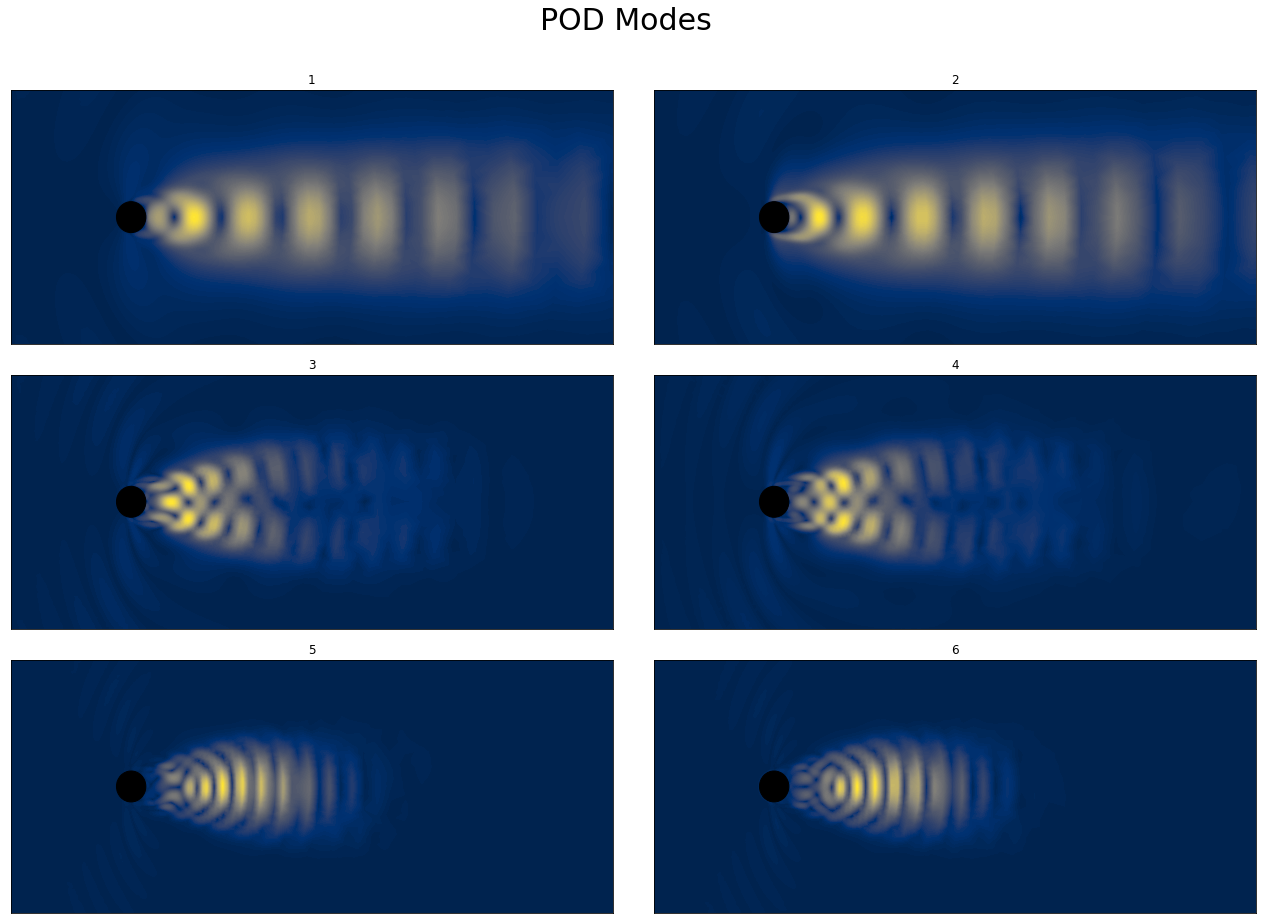

In [7]:
# visualization of leading six POD
if visual:
    
    # subplot canvas
    fig,ax = plt.subplots(3,2,figsize=(18,12))
    
    # force tight subplot layout
    fig.tight_layout(pad=1.0)
    
    # plot pod modes in grid
    plot_cylinder_data(x,y,np.sqrt(np.square(podModes[:n,0])+np.square(podModes[n:2*n,0])),ax=ax[0][0],zoom=True,cbar=False)
    plot_cylinder_data(x,y,np.sqrt(np.square(podModes[:n,1])+np.square(podModes[n:2*n,1])),ax=ax[0][1],zoom=True,cbar=False)
    plot_cylinder_data(x,y,np.sqrt(np.square(podModes[:n,2])+np.square(podModes[n:2*n,2])),ax=ax[1][0],zoom=True,cbar=False)
    plot_cylinder_data(x,y,np.sqrt(np.square(podModes[:n,3])+np.square(podModes[n:2*n,3])),ax=ax[1][1],zoom=True,cbar=False)
    plot_cylinder_data(x,y,np.sqrt(np.square(podModes[:n,4])+np.square(podModes[n:2*n,4])),ax=ax[2][0],zoom=True,cbar=False)
    plot_cylinder_data(x,y,np.sqrt(np.square(podModes[:n,5])+np.square(podModes[n:2*n,5])),ax=ax[2][1],zoom=True,cbar=False)
    
    # axis descriptions
    ax[0][0].set_title("1")
    ax[0][1].set_title("2")
    ax[1][0].set_title("3")
    ax[1][1].set_title("4")
    ax[2][0].set_title("5")
    ax[2][1].set_title("6")
    
    # figure title
    fig.suptitle("POD Modes", fontsize=30,y = 1.08)

In [17]:
# energy reconstruction threshold
acc = 0
dim = 0

# loop until threshold holds
while acc < eps:

    # increment necessary dim
    dim+=1

    # compute reconstruction capability
    acc = sum(S[:dim])/sum(S)    

# increment dim to always include complementary modes
if (includeAvg and dim % 2 == 0) or (not includeAvg and dim % 2 == 1):
    dim +=1

# printing info
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(dim))

Number of eigenvectors necessary for thresholded reconstruction: 	4


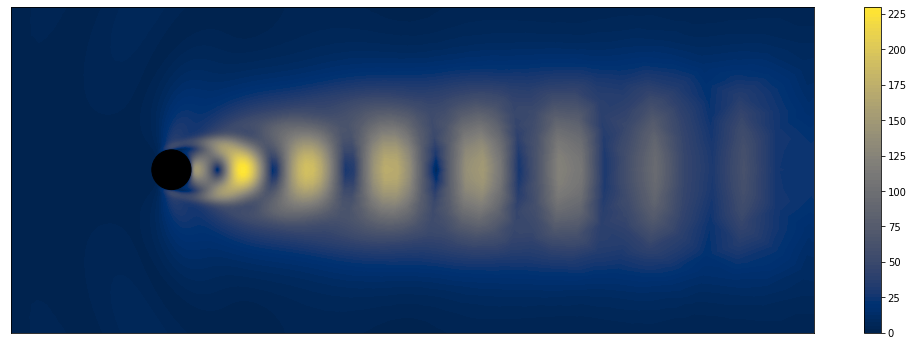

In [227]:
# reconstruction plotting 
reconIndex = 0
recNum = 2
recon = np.matmul(podModes[:,:recNum],coeffs[:recNum,reconIndex]) #+ qAvg
plot_cylinder_data(x,y,np.sqrt(np.square(recon[:n]) + np.square(recon[n:2*n]) ),zoom=True,cbar=True)

# Galerkin Projection

In [162]:
# general galerkin coeffiecients
[b1, b2, L1, L2, Q] = isentropic_projection(mesh,podModes[:,:dim],qAvg,skalar_product)

# additional control function coefficients
[d1,d2,f,g,h] = isentropic_control_projection(mesh,podModes[:,:dim],qAvg,qCon,skalar_product)

100%|██████████| 4/4 [00:00<00:00, 235.29it/s]


Projection based Galerkin coefficients in order: b1,b2,L1,L2,Q


100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

Additional projection based Galerkin coefficients for control in order: d1, d2, f, g, h


# Galerkin System

In [136]:
# initial conditions
a0 = coeffs[:dim,0]

# testing for different galerkin coefficients
phaseShift =  1.09 if stabilization else 1      # temporal shift
amplitudeShift = 2 if stabilization else 1      # artifical viscosity

# defining ode function for galerkin system
def galerkin_system(t,a):

    # set global coefficient references
    global Q, L1, L2, b1, b2, nu
    
    # initialize state flow
    a_dot = np.empty_like(a)

    # iterate dofs
    for k in range(a_dot.shape[0]):
        
        # compute dofs flow
        a_dot[k] = phaseShift * (amplitudeShift * nu * b1[k] + b2[k] + np.inner((amplitudeShift * nu * L1[k,:] + L2[k,:]), a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q[k]),np.expand_dims(a,1))) 
    
    # return flow
    return a_dot

# defined ode solver
def solver(f,interval,y0,dt):
    
    # get initial and end time
    t = interval[0]
    tmax = interval[1]

    # compute number of steps
    Nt = np.abs(int((tmax-t)/dt)) + 1
    
    # reverse time alternative
    alt = False
    if (tmax < t):
        dt *= -1
        alt = True
    
    # initialize trajectory matrix
    y = np.zeros((y0.shape[0],Nt))

    # initial conditions
    y[:,0] = y0
    
    # RK45 predictor-corrector loop
    for i in range(Nt-1):
        k1 = dt * f(t,y[:,i])
        k2 = dt * f(t+dt/2,y[:,i] + k1/2)
        k3 = dt * f(t+dt/2,y[:,i] + k2/2)
        k4 = dt * f(t+dt,y[:,i] + k3)
        k = (k1+2*k2+2*k3+k4)/6
        y[:,i+1] = y[:,i] + k
        t = t + dt  
    
    # structured return of state trajectory
    if alt:
        return np.flip(y,1)
    else:
        return y

In [137]:
# solve galerkin system with rk45 solver
stateTrajectory = solver(galerkin_system,(t0,tmax),a0,dt)

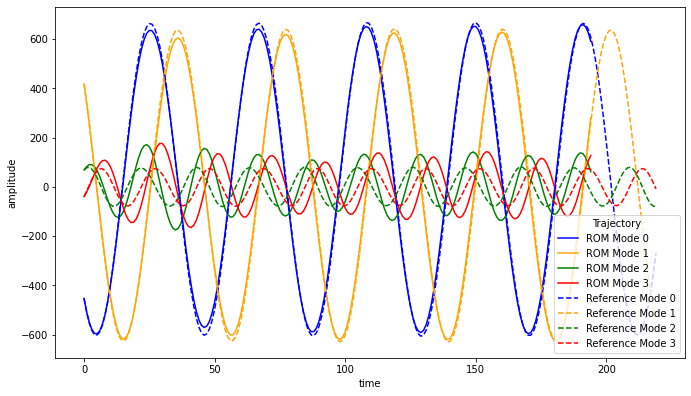

In [138]:
# plotting comparison to reference data
fig,ax = plt.subplots(1,1,figsize=(10,6))
fig.tight_layout(pad=3.0)
# loop four dofs
for i in range(0,4):
    ax.plot(stateTrajectory[i,:-300],label="ROM Mode "+str(i),c=colormap[i+1])
for i in range(0,4):
    ax.plot(coeffs[i,:],label="Reference Mode "+str(i),c=colormap[i+1],linestyle="dashed")

ax.legend(title="Trajectory")
ax.set_xlabel("time")
ax.set_ylabel("amplitude");

# Stability Properties

In [139]:
# newton method for critical point search
def jacobianGalerkinSystem(x, L, Q):
    
    # system dimensions
    dim = len(x)

    # initialize jacobian
    jacobian = np.zeros((dim,dim))
    
    #iterate dofs
    for k in range(dim):
        for j in range(dim):
            
            # matrix jacobian
            jacobian[k,j] = (L[k,j] + 2 * Q[k,j,j] * x[k])
            
            # iterate derivative of quadratic term
            for i in range(dim):
                jacobian[k,j] += (Q[k,i,j] + Q[k,j,i]) * x[i]
    
    # return with phase shift factor 
    return jacobian * phaseShift

# initial guess for equilibrium point
equi = np.ones(dim)

# initial state value
fx = galerkin_system(0,equi)

# linear factor
L = (amplitudeShift * nu * L1 + L2)

# iteration loop
while not np.isclose(fx,0).all():
    
    # jacobian at point
    jac = jacobianGalerkinSystem(equi,L,Q)
    
    # solving linear system for equilibirum update
    equi = np.linalg.solve(jac, - fx) + equi
    
    # solve for function value
    fx = galerkin_system(0,equi)

print("Equilibrium: " + str(equi))

Equilibrium: [ 30.73546576   5.58047708   5.65760552 -11.99434639]


In [140]:
# evaluate jacobian at equilibrium -> linearized matrix system at equi
A = jacobianGalerkinSystem(equi,L,Q)

# lyapunov indirect method -> linearization 
w, _ = np.linalg.eig(A)

# checking for stability property
if (np.real(w) < 0).all():
    print("System is stable around equilibrium!")
elif (np.real(w) > 0).any():
    print("System is unstable around equilibrium!")
else:
    print("No conclusions about stabilty from linearization!")

System is unstable around equilibrium!


# Optimal Control

In [141]:
class controlOptimization:

    def __init__(self, designDim, timeInterval, dt, T, a0, phi0, control0, maxControl, stabilization=False):
        
        self.designDim = designDim                      # number of design variables
        self.designVariables = np.zeros(designDim)      # design variables

        # temporal setup
        self.dt = dt                                    # time step
        self.t0 = timeInterval[0]                       # starting time
        self.tmax = np.ceil(timeInterval[1] / dt) * dt  # adapted max time
        self.T = T                                      # shed period
        self.Nt = int(self.tmax/dt) + 1                 # number of timesteps (incl. initial time)

        # initial conditions
        self.a0 = a0                                    # start activation
        self.phi0 = phi0                                # final costate 
        self.control0 = control0                        # start control

        # misc
        self.dim = len(a0)                              # system dimension
        self.maxControl = maxControl                    # max allowable control
        self.N = 1e-4                                      # exponential weight for control 
        self.cost = 0                                   # inital cost
        self.phaseShift = 1.09 if stabilization else 1  # temporal shift
        self.amplitudeShift = 2 if stabilization else 1 # artifical viscosity coefficient
        self.nu = nu * self.amplitudeShift              # viscosity

        # optimizaiton control
        self.epsilon = 1e-6                             # stop criterion for gradient and or cost function change
        self.alpha = 1e-1#1                                  # step size for gradient
        self.maxIter = 10000                            # max number of iterations
        self.iteration = 0                              # optimization step
        self.lowChangeIter = 0                          # number of iteration with break criterion

        # initialize arrays 
        self.a = np.zeros((self.dim, self.Nt))          # system trajectory
        self.phi = np.zeros((self.dim, self.Nt))        # costate trajectory
        self.gamma = np.zeros(self.Nt)                  # control trajectory
        self.grad = np.zeros(self.designDim)            # gradient value


    # printing statements
    def status(self,print_string):
        print(f'{print_string:{"-"}<80}')


    # functions for single timestep output
    def control(self,t):
        # discrete control function
        tmp = self.control0 * (1 - t / self.T)
        for m in range(self.designDim):
            tmp += self.designVariables[m] * np.sin((m+1) * np.pi * t * 0.5 / self.T)
        return tmp


    def control_derivative(self,t):
        # dertivative of discrete control function 
        tmp = - self.control0 * (1 / self.T)
        for m in range(self.designDim):
            tmp += self.designVariables[m] * np.cos((m+1) * np.pi * t * 0.5 / self.T) * (m+1) * np.pi * 0.5 / self.T
        return tmp


    def activation(self,t):
        # interpolation of known state trajectory a
        if t % self.dt != 0:
            return 0.5 * (self.a[:,int(np.ceil(t/self.dt))] + self.a[:,int(np.floor(t/self.dt))])
        else:
            return self.a[:,int(t/self.dt)]     


    # RK45 ODE solver for forward/reverse time solve
    def solver(self,f,interval,y0,dt):
        
        # get initial and end time
        t = interval[0]
        tmax = interval[1]

        # compute number of steps
        Nt = np.abs(int((tmax-t)/dt)) + 1
        
        # reverse time alternative
        alt = False
        if (tmax < t):
            dt *= -1
            alt = True
        
        # initialize trajectory matrix
        y = np.zeros((y0.shape[0],Nt))

        # initial conditions
        y[:,0] = y0
        
        # RK45 predictor-corrector loop
        for i in range(Nt-1):
            k1 = dt * f(t,y[:,i])
            k2 = dt * f(t+dt/2,y[:,i] + k1/2)
            k3 = dt * f(t+dt/2,y[:,i] + k2/2)
            k4 = dt * f(t+dt,y[:,i] + k3)
            k = (k1+2*k2+2*k3+k4)/6
            y[:,i+1] = y[:,i] + k
            t = t + dt  
        
        # structured return of state trajectory
        if alt:
            return np.flip(y,1)
        else:
            return y
    

    # ODE system dynamics
    def costate_problem(self, t, phi):
        # adapted costate problem!

        # system dimenison
        n = phi.shape[0]

        # initialize output
        phi_dot = np.zeros(n)

        # retrieve time dependent control and dof values
        a = self.activation(t)
        gamma = self.control(t)
        
        # loop dofs
        for k in range(n):

            # costate linear vector
            A = np.zeros(n)
            for i in range(n):
                tmp = 0
                for j in range(n):
                    tmp += (Q[i][k,j] + Q[i][j,k]) * a[j]
                A[i] = - (self.nu * L1[i][k] + L2[i][k] + tmp + g[i,k] * gamma)
            
            # costate flow
            phi_dot[k] = np.inner(A,phi) + 2 * a[k]
        
        return phi_dot


    def galerkin_system(self, t, a):
        
        # system dimenison
        n = a.shape[0]
        
        # initialize output
        a_dot = np.zeros(n)
        
        # retrieve time dependent control -derivative values
        gamma = self.control(t)
        dgamma = self.control_derivative(t)
        
        # iterate system dof
        for k in range(n):
            a_dot[k] = self.nu * b1[k] + b2[k] + np.inner((self.nu * L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q[k]),np.expand_dims(a,1)) + gamma * (self.nu * d1[k] + d2[k] + np.inner(g[k],a) + gamma * f[k]) + h[k] * dgamma
        
        # return dof flow
        return self.phaseShift * a_dot


    # discrete gradient computation   
    def gradient_function(self,phi):
        
        # initialize gradient
        gradient = np.zeros(self.designDim)
        
        # loop design dimension
        for m in range(self.designDim):
            
            # loop time steps
            for n in range(self.Nt):    
                
                # compute physical time
                t = self.t0 + n * self.dt
                
                # compute control at time
                gamma = self.control(t)
                
                # temporary value
                tmpTime = 0
                
                # loop dofs
                for k in range(self.dim):
                    
                    # computing costate vector problem
                    A = np.zeros(self.dim)
                    for i in range(self.dim):
                        tmp = 0
                        for j in range(self.dim):
                            tmp += (Q[i][j,k] + Q[i][k,j]) * self.a[j,n]
                        A[i] = - (self.nu * L1[i][k] + L2[i][k] + tmp + g[i][k] * gamma)
                    
                    # temporary value
                    tmp = 0

                    # summation over dof in dof
                    for i in range(self.dim):
                        tmp  += h[k] * A[i] * self.phi[i,n] - g[k][i] * self.a[i,n] * self.phi[k,n]
                    
                    # dof specific summation
                    tmpTime += tmp - (self.nu * d1[k] + d2[k] + 2 * gamma * f[k]) * self.phi[k][n] + h[k] * 2 * self.a[k][n]
                
                # design variable based gradient
                gradient[m] += self.dt * (tmpTime  + np.exp(self.N * (np.power(gamma,2) - np.power(self.maxControl,2))) * 2 * self.N * gamma) * np.sin((m+1) * np.pi * t * 0.5 / self.T)
        
        # return
        return gradient


    def cost_function(self):
        
        # inital cost
        cost = 0

        # loop time steps
        for n in range(self.Nt - 1):
            
            # physical time
            t = self.t0 + n * self.dt
            
            # cost functional at t
            cost += self.dt * (np.sum(np.square(self.a[:,n]) + np.exp(self.N * (np.power(self.control(t),2)-np.power(self.maxControl,2)))))
        
        # return summed cost
        return cost


    def side_constraints(self):
        
        # initial cost
        constraintCost = np.zeros(self.dim)
        
        # loop time steps
        for n in range(self.Nt-1):
            
            # physical time
            t = self.t0 + n * self.dt
            
            # flow by dynamics
            aDot = self.galerkin_system(t,self.a[:,n])
            
            # loop dofs
            for k in range(self.dim):

                # compute deviation to system dynamics
                constraintCost[k] += self.dt * self.phi[k,n] * ((self.a[k,n+1] - self.a[k,n])/self.dt - aDot[k])
        
        # return side constraint cost
        return np.sum(constraintCost)


    def step(self):

        # construct control trajectory
        for n in range(self.Nt):
            self.gamma[n] = self.control(self.t0 + n * self.dt)

        # solving galerkin system
        self.a = self.solver(self.galerkin_system,[self.t0,self.tmax],self.a0,self.dt)

        if np.isnan(self.a).any():
            return 0

        # solving costate ode dynamics in reverse time
        self.phi = self.solver(self.costate_problem,[self.tmax,self.t0],self.phi0,self.dt)
        #self.phi = np.flip(solve_ivp(self.costate_problem,(self.tmax,self.t0),self.phi0,t_eval=np.linspace(self.tmax,self.t0,self.Nt)).y,1)

        # computing gradient step function
        self.grad = self.gradient_function(self.phi)

        # gradient clipping
        
        if np.isnan(self.grad).any():
            return 0

        # perform update step
        self.designVariables -= np.clip(self.alpha * self.grad,-100,100)

        # computing cost function
        self.cost = self.cost_function()

        # increment iteration
        self.iteration += 1

        return 1


    def optimize(self):

        # initial optimization status
        self.status("Optimization started with parameters ")
        self.status("Learning Rate: " + str(self.alpha))
        self.status("Iteration Limit: " + str(self.maxIter))

        # optimization loop
        for s in range(self.maxIter):
            
            # previouse cost
            prevCost = self.cost
            
            # computation step
            if not self.step():
                print("Gradient became nan! Optimization interrupted")
                return 0
            
            # step status
            sys.stdout.write("\r"f'{"Iteration: " + str(self.iteration):{""}<20}' + f'{"Cost: " + str(self.cost):{""}<60}')
            sys.stdout.flush()
            
            # discontinuation criterion
            if np.abs(prevCost - self.cost) < self.epsilon:
                self.status("")
                self.status("Optimization converged and finished! ")
                break

    
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def testGradientFunction(self,testVariable):
        # testing gradient function with finite difference method for design variable
        
        # perform inital optimizer step
        if self.iteration==0:
            self.step()

        # variation of design variable
        variation = 1e-12

        # compute cost as is
        cost0 = self.cost_function() - np.sum(self.side_constraints())

        # compute gradient as is
        grad = self.gradient_function(self.phi)

        # make small perturbation on selected design parameter
        self.designVariables[testVariable] += variation

        # run dynamic, costate system and control computation
        for n in range(self.Nt):
            self.gamma[testVariable] = self.control(self.t0 + n * self.dt)
        self.a = self.solver(self.galerkin_system,[self.t0,self.tmax],self.a0,self.dt)
        self.phi = self.solver(self.costate_problem,[self.tmax,self.t0],self.phi0,self.dt)
        
        # compute new cost function
        cost1 = self.cost_function() - np.sum(self.side_constraints())
        
        # finite difference
        approxGrad = (cost1 - cost0) / variation
        
        # printing result
        print("Gradient Function: " + str(grad[testVariable]),"\nFinite Difference: "+ str(approxGrad))


In [142]:
optimizer = controlOptimization(80, [0,10*detPer], dt, 10*detPer, a0, np.repeat(phi0,dim), control0, 4000, True)

In [143]:
optimizer.optimize()

Optimization started with parameters -------------------------------------------
Learning Rate: 0.1--------------------------------------------------------------
Iteration Limit: 10000----------------------------------------------------------
Iteration: 1        Cost: 124946.7249085066                                     

KeyboardInterrupt: 

In [ ]:
def plot_optimization_results():
    # initialize canvas
    fig,ax = plt.subplots(3,1,figsize=(15,10))
    ax[0].set_title("")

    # plot curves
    for i in range(optimizer.dim):
        ax[0].plot(optimizer.a[i,:],label="ROM Mode "+str(i+1),c=colormap[i+1])
        ax[0].plot(stateTrajectory[i,:],c=colormap[i+1],linestyle='dotted')
        ax[1].plot(optimizer.phi[i,:],label="Costate Function "+str(i+1),c=colormap[i+1])

    for i in range(optimizer.dim):
        ax[0].plot(stateTrajectory[i,:],c=colormap[i+1],linestyle='dashed',label="Reference Mode "+str(i+1))
    # plot control function
    ax[2].plot(optimizer.gamma, label="Control Function")

    # force legends
    ax[0].legend()
    ax[1].legend()
    ax[2].legend();

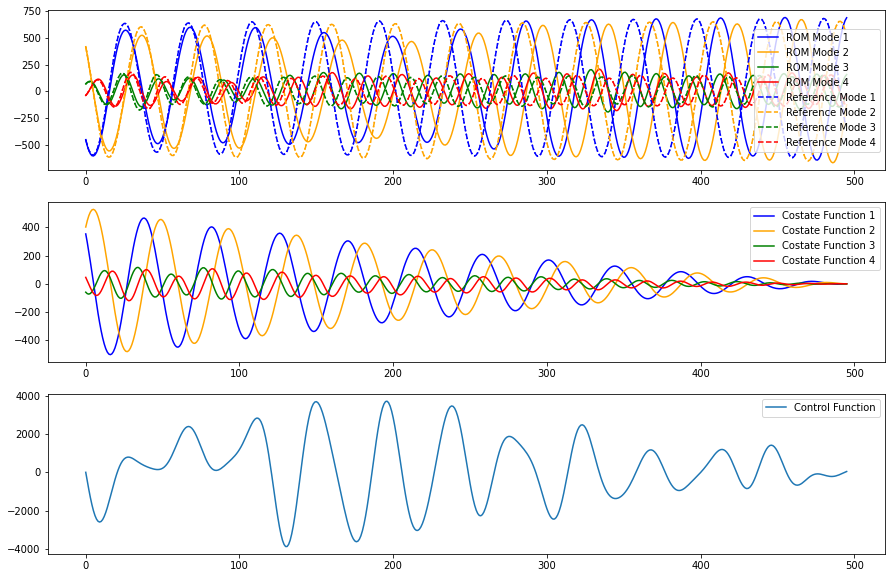

In [120]:
plot_optimization_results()

In [22]:
def plot_objective_function():
    fig,ax = plt.subplots(1,1,figsize=(10,6))
    ax.semilogy(temporalSpan,np.sum(np.square(optimizer.a/uInfty),0)[:-1],label="optimized")
    ax.semilogy(np.linspace(0,dt_ref*(len(coeffs[i,:]-1)),len(coeffs[i,:])),np.sum(np.square(coeffs[:dim,:]/uInfty),0),label="uncontrolled")
    ax.legend(title="Legend",loc=1)
    ax.set_xlabel("time")
    ax.set_ylabel("amplitude");